# 分类决策树

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [4]:
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [8]:
from sklearn.tree import export_graphviz
with open('iris_tree.dot', 'w') as f:
    export_graphviz(tree_clf, out_file=f, feature_names=iris.feature_names[2:],
                    class_names=iris.target_names, rounded=True, filled=True)

In [9]:
tree_clf.predict_proba([[5, 1.5]]), tree_clf.predict([[5, 1.5]])

(array([[0.        , 0.90740741, 0.09259259]]), array([1]))

scikit-learn的决策树模块默认使用的是基尼系数，如要使用信息熵，需设定超参数criterion='entropy'

- 基尼系数 $G_i = 1 - \sum^n_{k=1}p_{i,k}^2$

- 信息熵 $H_i = -\sum^n_{k=1,P_{i,k}\neq 0}p_{i,k}log(p_{i,k})$

基尼系数倾向于从树枝中分裂出最常见的类别，而信息熵倾向于产生更为平衡的二叉树

**超参数的正则化：**

- max_depth：限定树的最大深度，默认为None，无限制

- min_samples_split: 分裂前节点必须有的最小样本数，默认为2

- min_samples_leaf：叶节点比必须有的最小样本数，默认为1

- max_leaf_nodes: 最大叶节点数量，默认为None

- max_features: 分裂每个节点时评估的最大特征数量，默认为None

In [10]:
tree_clf.feature_importances_
'''
在决策树或是随机森林中，都有参数feature_importances_,用来输出各特征的重要程度
'''

array([0.56199095, 0.43800905])

In [11]:
for name, score in zip(iris['feature_names'][2:], tree_clf.feature_importances_):
    print(name, score)

petal length (cm) 0.5619909502262443
petal width (cm) 0.4380090497737556


# 回归决策树

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [12]:
with open('iris_tree_reg.dot', 'w') as f:
    export_graphviz(tree_reg, out_file=f, feature_names=iris.feature_names[2:],
                    class_names=iris.target_names, rounded=True, filled=True)

**不稳定性**： 

对数据的旋转非常敏感，可能导致泛化不佳。可实现使用PCA使数据位于一个更好的方向

# 集成学习

- Voting

- Bagging

- Boosting

## Voting（硬投票）

硬投票策略：选中模型中出现次数最多的结果

软投票策略：选出在各模型上平均概率最高的结果（模型本身需要支持输出概率结果）

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [15]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(clf.__class__.__name__, accuracy_score(y, y_pred))

LogisticRegression 0.9666666666666667
RandomForestClassifier 0.9933333333333333
SVC 0.9533333333333334
VotingClassifier 0.9666666666666667


## Voting（软投票）

In [16]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [17]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(clf.__class__.__name__, accuracy_score(y, y_pred))

LogisticRegression 0.9666666666666667
RandomForestClassifier 0.9933333333333333
SVC 0.9533333333333334
VotingClassifier 0.9733333333333334


## Bagging

全称：Bootstrap Aggregating，即采用Bootstrap方法（训练实例可被统一模型多次采用），非Bootstrap为**Pasting**

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
'''
bootstrap=False即为Pasting
oop_score=True可进行模型的验证评估，因为对于每个模型，大约有37%的数据未被抽样过，
可用来作为验证集，通过bag_clf.obb_score__查看整体结果，通过bag_clf.obb_decision_function
查看各模型的独立结果
'''
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


Random Patches: 对训练实现和特征都进行抽样

随机子空间法: 保留所有训练实例(bootstrap=False, max_samples=1.0)，但对特征进行抽样(bootstrap_features=True, max_features<1.0)

## 随机森林

属于Bagging的应用 

In [5]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=0, max_leaf_nodes=16, n_jobs=-1)
'''
与这个等效：
rnd_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=16), 
            n_estimatores=100, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=0)
'''
rnd_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## 极端随机树

在随机森林中，每节点分裂时仅考虑特征的一个子集，如果对每个特征使用随机的阈值，而不是搜索出的最佳阈值，可能使决策树的生长更加随机

这种极端随机的决策树组成的森林，称为极端随机树（Extra-Trees）

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

## AdaBoost

依次叠加模型到所累积的模型上，增加整体模型效果，可看成线性向前的模型叠加

**巨大缺点**：无法并行

In [14]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                             learning_rate=0.5, algorithm='SAMME.R', )
ada_clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

## Gradient Boosting

不像AdaBoost在每个迭代中调整实例权重，而是让新的模型针对前一个模型的残差进行拟合，一个应用模型为：**GBDT**（梯度提升决策树）

**构建流程如下：**

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [20]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [21]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [22]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

**或者使用包装好的GradientBoostingRegressor**

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

提前收敛：当不再明显优化时，即可停止

可在超参数中设置warm_start=True

## Stacking堆叠法

基于简单的想法：与其使用一些简单的函数来聚合集成所有预测器的预测，何不专门训练一个模型来执行这个聚合操作

# 决策树及随机森林

决策树是一极其常见和使用的机器学习方法，通过不同指标将**特征**作为结点构成一个树形结构，最后生成一个决策树，可用于未知数据的预测。

决策树既可用于回归问题也可用于分类问题，对应的树也可称为回归树和分类树。

通过集成学习方法，可将多个决策树构成一个随机森林，提高整体模型的性能。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

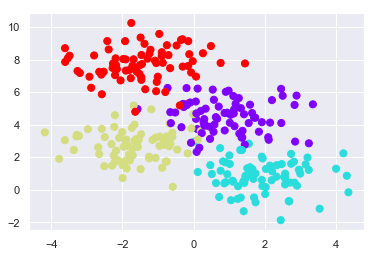

In [3]:
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='rainbow')

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [15]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    # plot the training data
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                        np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # plot colorful graph for the predicted data
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes+1) - 0.5, cmap=cmap, zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

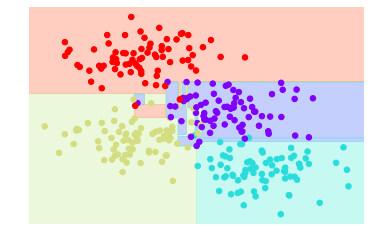

In [16]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [17]:
import helpers
helpers.plot_tree_interactive(X, y)

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

<function helpers.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

正常的决策树fit很容易出现过拟合现象。

防止过拟合手段：

- 通过特定规则剪枝

- 提早收敛

- 引入正则化因子

- 集成学习（即随机森林）

In [18]:
helpers.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

# 随机森林（一般通过Bagging策略生成）

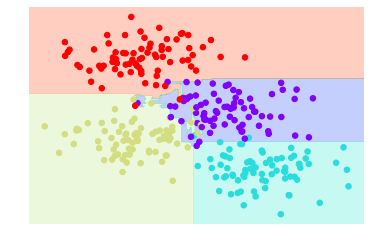

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

visualize_classifier(bag, X, y)

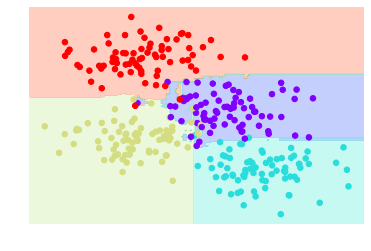

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y)

## 随机森林回归

In [26]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise= sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation
## 生成一组数据，数据又快慢震荡及噪声项构成

<ErrorbarContainer object of 3 artists>

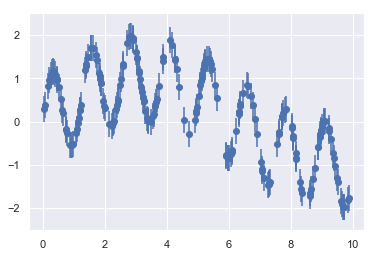

In [27]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

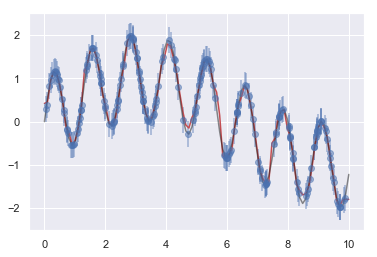

In [28]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 100)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-k', alpha=0.5)

# 案例：随机森林识别首写字母

In [29]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

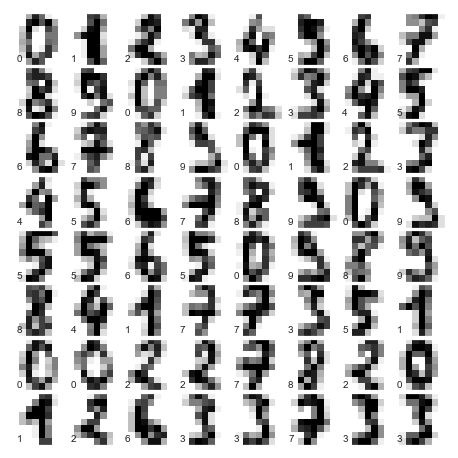

In [32]:
# create plot object
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot digits with 8*8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # annotation the right number
    ax.text(0, 7, str(digits.target[i]))

In [33]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [34]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.98      0.99        49
           8       0.96      0.98      0.97        47
           9       0.98      0.98      0.98        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



通过混淆矩阵可以更好地验证结果

Text(89.18, 0.5, 'predicted label')

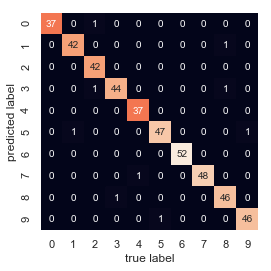

In [35]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# 总结

在实际使用中，通常使用的并不是单一的决策树，而是通过集成学习（Bagging）所得到的随机森林。

随机森林有如下几大优势：

- 原理较为简单，模型训练速度较快。

- 多任务可以并行执行计算（即单个决策树的生成），因为每棵树的生成都是独立的

- 多棵树可以进行概率分类：多个决策树（亦称评估器）间的多数投票可以给出概率的估计值（sklearn中，可使用predict_proba()方法）

- 模型无参数设定，使用灵活，在其它评估器欠拟合的任务中表现突出